# Tutorial 6 - Additive Factors Model and Performance Factors Analysis
---

<i>This tutorial is based on [this Python implementation of AFM by Prof. Christopher J. MacLellan](https://chrismaclellan.com/blog/modeling-student-learning-in-python)
    
In this tutorial we will explore two other knowledge tracing models you have seen in the lecture: the Additive Factors Model (AFM) and the Performance Factors Analysis (PFA). For this purpose, we will use the pyAFM package, that you will have to install manually. We have provided you with all the necessary files, you just need to run the following command from the terminal:
    
`python3 setup.py install`
    
__Please note:__ When using EPFL Noto, you will have to work in a virtual environment to be able to install the package.

In [11]:
import pandas as pd
from tabulate import tabulate

import numpy as np
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer
import matplotlib.pyplot as plt
from scipy.stats import beta

from pyafm.custom_logistic import CustomLogistic
from pyafm.bounded_logistic import BoundedLogistic
from pyafm.process_datashop import read_datashop_student_step
from pyafm.roll_up import transaction_to_student_step
from pyafm.util import invlogit

## 1 Data import and first inspection
---
Let's first take a look at the data we are going to analyze in this tutorial, [the Geometry 96-97 dataset](https://pslcdatashop.web.cmu.edu/LearningCurve?datasetId=76). The data was taken from [Carnegie Mellon's Datashop](https://pslcdatashop.web.cmu.edu/about/), an open repository for educational research data. The platform also provides a set of analysis and reporting tools (which among other things also use AFM). From the [official description of the dataset](https://pslcdatashop.web.cmu.edu/LearningCurve?datasetId=76) it can be understood that the data was collected from __59 students__ who worked using the area unit of the Geometry [Cognitive Tutor](https://en.wikipedia.org/wiki/Cognitive_tutor) (an intelligent tutoring system, ITS) in the school year 1996-1997.

In [12]:
# Importing the dataset
df = pd.read_csv("student_data.txt", sep="\t")

# Print the dimension of the dataframe
print(df.shape)

# Display first five entries of the dataframe
df.head()

(5104, 199)


,Row,Sample,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,...,Predicted Error Rate (new_),KC (original_geometryConcept),Opportunity (original_geometryConcept),Predicted Error Rate (original_geometryConcept),KC (our model),Opportunity (our model),Predicted Error Rate (our model),KC (xDecmpTrapCheat),Opportunity (xDecmpTrapCheat),Predicted Error Rate (xDecmpTrapCheat)
0,1,All Data,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,Unit Area,RECTANGLE_ABCD,1,(AREA QUESTION1),1996-02-01 00:00:48,1996-02-01 00:00:48,1996-02-01 00:00:48,...,0.2117,ALT:area,1,0.3854,square-area,1,0.2179,parallelogram-area,1,0.2116
1,2,All Data,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,Unit Area,RECTANGLE_ABCD,1,(HEIGHT QUESTION2),1996-02-01 00:00:48,1996-02-01 00:02:56,1996-02-01 00:02:56,...,0.3359,ALT:side,1,0.4977,square-area,2,0.2139,parallelogram-area,2,0.2086
2,3,All Data,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,Unit Area,RECTANGLE_ABCD,1,(BASE QUESTION3),1996-02-01 00:02:56,1996-02-01 00:03:25,1996-02-01 00:03:25,...,0.2759,ALT:side,2,0.4977,square-area,3,0.2100,parallelogram-area,3,0.2056
3,4,All Data,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,Unit Area,BUILDING_A_SIDEWALK,1,(POOL-AREA QUESTION1),1996-02-01 00:04:15,1996-02-01 00:04:15,1996-02-01 00:04:15,...,0.1890,ALT:area,2,0.3840,square-area,4,0.2062,parallelogram-area,4,0.2026
4,5,All Data,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,Unit Area,BUILDING_A_SIDEWALK,1,(LARGE-RECTANGLE-AREA QUESTION1),1996-02-01 00:04:15,1996-02-01 00:04:27,1996-02-01 00:04:27,...,0.1288,ALT:area,3,0.3826,square-area,5,0.2024,parallelogram-area,5,0.1997


We can see that each row describes the interaction of a student (identifiable by the unique "Anon Student ID") with a specific question item in the ITS. However, we can also see that with 199 columns, there is a lot of information for each row. To better understand the structure of this dataset, let's print all the column names.

In [13]:
# Print names of all columns in the dataframe
for col_name in df.columns: 
    print(col_name)

Row
Sample
Anon Student Id
Problem Hierarchy
Problem Name
Problem View
Step Name
Step Start Time
First Transaction Time
Correct Transaction Time
Step End Time
Step Duration (sec)
Correct Step Duration (sec)
Error Step Duration (sec)
First Attempt
Incorrects
Hints
Corrects
Condition
KC (Area)
Opportunity (Area)
Predicted Error Rate (Area)
KC (Circle-Collapse)
Opportunity (Circle-Collapse)
Predicted Error Rate (Circle-Collapse)
KC (Concepts)
Opportunity (Concepts)
Predicted Error Rate (Concepts)
KC (DecompArithDiam)
Opportunity (DecompArithDiam)
Predicted Error Rate (DecompArithDiam)
KC (DecompArithDiam2)
Opportunity (DecompArithDiam2)
Predicted Error Rate (DecompArithDiam2)
KC (Decompose)
Opportunity (Decompose)
Predicted Error Rate (Decompose)
KC (DecomposeArith)
Opportunity (DecomposeArith)
Predicted Error Rate (DecomposeArith)
KC (Decompose_height)
Opportunity (Decompose_height)
Predicted Error Rate (Decompose_height)
KC (Geometry)
Opportunity (Geometry)
Predicted Error Rate (Geometr

We can see that starting from the 20th column, the dataframe has a repetitive structure with blocks of three columns that always have the same names (KC, Opportunity, Predicted Error Rate), but vary in the strings between the parantheses (e.g. Area, Circle-Collapse, Concepts etc.). As a matter of fact, when we export the dataset from CMU Datashop, we also include the different knowledge component (KC) models that were run on the dataset. Therefore, we can also observe to which KC of a model each question item corresponds to, how many practice opportunities a student already had for that KC, and what was the predicted error rate for that KC after the student answered that question. From the [official description of the dataset](https://pslcdatashop.web.cmu.edu/LearningCurve?datasetId=76) it can be seen that different KC models have been explored, each with different numbers and definitions of KCs (e.g. "Area" with only 2 KCs and "Item" with 139 KCs). In our tutorial we will focus our analyses on the same model as used by [MacLellan](https://chrismaclellan.com/blog/modeling-student-learning-in-python), i.e. __LFASearchAICWholeModel3__, which is one of the best fitting models. 

In the following, we will reduce our dataframe to the columns which are relevant for our analyses.

In [14]:
# Reduce dataframe to columns that we need for our analyses
df2 = df[["Anon Student Id", "Problem Name", "Step Name", "First Attempt", "KC (LFASearchAICWholeModel3)", "Opportunity (LFASearchAICWholeModel3)", "Predicted Error Rate (LFASearchAICWholeModel3)"]]

# Display first ten entries for a particular student
df2[df2["Anon Student Id"] == "Stu_02ee1b3f31a6f6a7f4b8012298b2395e"].head(10)

,Anon Student Id,Problem Name,Step Name,First Attempt,KC (LFASearchAICWholeModel3),Opportunity (LFASearchAICWholeModel3),Predicted Error Rate (LFASearchAICWholeModel3)
0,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(AREA QUESTION1),correct,Geometry*parallelogram-area,1,0.2478
1,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(HEIGHT QUESTION2),correct,Geometry*parallelogram-area,2,0.2427
2,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(BASE QUESTION3),correct,Geometry*parallelogram-area,3,0.2376
3,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(POOL-AREA QUESTION1),correct,Geometry*parallelogram-area*Textbook_New_Decom...,1,0.1346
4,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(LARGE-RECTANGLE-AREA QUESTION1),correct,Geometry*parallelogram-area*Textbook_New_Decom...,2,0.1146
5,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(SIDEWALK-AREA QUESTION1),correct,Geometry*Textbook_New_Decompose-circle-area,1,0.3904
6,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(POOL-AREA QUESTION2),correct,Geometry*parallelogram-area*Textbook_New_Decom...,3,0.0973
7,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(LARGE-RECTANGLE-AREA QUESTION2),correct,Geometry*parallelogram-area*Textbook_New_Decom...,4,0.0824
8,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(SIDEWALK-AREA QUESTION2),correct,Geometry*Subtract*Textbook_New_Decompose-compo...,1,0.1548
9,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,BUILDING_A_SIDEWALK,(POOL-AREA QUESTION3),correct,Geometry*parallelogram-area*Textbook_New_Decom...,5,0.0696


In [15]:
# Display first ten entries for a particular KC
df2[df2["KC (LFASearchAICWholeModel3)"] == "Geometry*parallelogram-area"].head(10)

,Anon Student Id,Problem Name,Step Name,First Attempt,KC (LFASearchAICWholeModel3),Opportunity (LFASearchAICWholeModel3),Predicted Error Rate (LFASearchAICWholeModel3)
0,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(AREA QUESTION1),correct,Geometry*parallelogram-area,1,0.2478
1,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(HEIGHT QUESTION2),correct,Geometry*parallelogram-area,2,0.2427
2,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,RECTANGLE_ABCD,(BASE QUESTION3),correct,Geometry*parallelogram-area,3,0.2376
12,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,PARALLELOGRAM_ABDE,(AREA QUESTION1),correct,Geometry*parallelogram-area,4,0.2326
13,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,PARALLELOGRAM_ABDE,(HEIGHT QUESTION2),incorrect,Geometry*parallelogram-area,5,0.2277
14,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,PARALLELOGRAM_ABDE,(BASE QUESTION3),correct,Geometry*parallelogram-area,6,0.2229
15,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,SQUARE_ABCD,(AREA QUESTION1),correct,Geometry*parallelogram-area,7,0.2181
16,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,SQUARE_ABCD,(HEIGHT QUESTION2),correct,Geometry*parallelogram-area,8,0.2134
17,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,SQUARE_ABCD,(BASE QUESTION3),correct,Geometry*parallelogram-area,9,0.2088
18,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,PAINTING_THE_WALL,(DOOR-AREA QUESTION1),correct,Geometry*parallelogram-area,10,0.2043


Above we show parts of the reduced dataframe, displaying only the first entries for the same student and the first entries for the same KC (which happens to be for the same student as well). We can see that with each time that the student is answering a question related to a KC, the count for the opportunity related to that KC increments. Moreover, we can observe that the predicted error rate decreases with each learning opportunity, which is coherent with one of the AFM assumptions (Students learn with each practice opportunity). Further we can see that the questions are organized in a two level structure: there are general problems, specified by "Problem Name", each having different questions ("Step Name"). A question item that can be related to a KC, is therefore specified by both the Problem Name and Step Name. For instance, (AREA QUESTION1) of RECTANGLE_ABCD can be associated with the KC Geometry-parallelogram-area, but also (HEIGHT QUESTION2) of SQUARE_ABCD.

Moreover, the dataframes show whether the first attempt to answer an item was correct or not.

With this knowledge, we can know try to fit a AFM model using pyAFM.

## 2 Using pyAFM
---
To run the AFM model, we will rely on the functions delivered by the pyAFM package. 

First we will extract the relevant data from the student_data.txt using the read_datashop_student_step function. When executing the code, you will be asked to specify the model you want to use. As introduced before, in the following we will work with model (18) LFASearchAICWholeModel3.


In [16]:
# Extract data from txt file using read_datashop_student_step
stu_data_file = open("student_data.txt", 'r')
kcs, opps, y, stu, student_label, item_label = read_datashop_student_step(stu_data_file)


Found these KC models:
  (1) Area
  (2) Circle-Collapse
  (3) Concepts
  (4) DecompArithDiam
  (5) DecompArithDiam2
  (6) Decompose
  (7) DecomposeArith
  (8) Decompose_height
  (9) Geometry
  (10) Item
  (11) Item Model
  (12) JohnsNewModel
  (13) LFASearchAIC1_no_textbook_new_decompose
  (14) LFASearchAIC1_with_texkbook_new_decompose
  (15) LFASearchAIC2_no_textbook_new_decompose
  (16) LFASearchAIC2_with_texkbook_new_decompose
  (17) LFASearchAICWholeModel2
  (18) LFASearchAICWholeModel3
  (19) Lasso Model
  (20) LuS-divide-compose-by-addition
  (21) Merge-Trap
  (22) Monica
  (23) Orig - Trap-Merge
  (24) Orig-trap-merge
  (25) Orige-trap-merge
  (26) Original
  (27) Original-test
  (28) Original-trap-merge
  (29) Single-KC
  (30) Single_Plus_Unique
  (31) Textbook
  (32) Textbook New
  (33) Textbook_New_Decompose
  (34) Unique-step
  (35) WESST
  (36) Yu-Ju_Textbook_modified
  (37) Yu-Ju_Textbook_modified2
  (38) combineTraps
  (39) combineTraps-diffSize
  (40) hLFASearchAICWhole

Enter the number of which one you want to use:  18


__Question:__ What happens after you enter "18"? Try to understand what the read_datashop_student_step function does - you can find the function in the process_datashop.py file. 

__======== YOUR ANSWER HERE ========__

In the following, the data from stu, kcs and opps is used to prepare the matrix X, which will then be used to train our AFM model. Moreover, the parameters for the [L2 regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) and the bounds to be used with the classifier are specified.

In [17]:
# Get everything in the right matrix format
sv = DictVectorizer()
qv = DictVectorizer()
ov = DictVectorizer()
S = sv.fit_transform(stu)
Q = qv.fit_transform(kcs)
O = ov.fit_transform(opps)
X = hstack((S, Q, O))
y = np.array(y)

# Regularize the student intercepts
l2 = [1.0 for i in range(S.shape[1])]
l2 += [0.0 for i in range(Q.shape[1])]
l2 += [0.0 for i in range(O.shape[1])]

# Bound the learning rates to be positive
bounds = [(None, None) for i in range(S.shape[1])]
bounds += [(None, None) for i in range(Q.shape[1])]
bounds += [(0, None) for i in range(O.shape[1])]

X = X.toarray()
#X2 = Q.toarray()

__Question:__ Which dimensions do S, Q, O, X and y have? How many coefficients will we have to estimate? 

__======== YOUR ANSWER HERE ========__

Using the X matrix and the y array, we can now fit a model using the CustomLogistic() function of the pyAFM package. As described by [MacLellan](https://pslcdatashop.web.cmu.edu/LearningCurve?datasetId=76), this customized implementation of the logistic regression classifier allows to restrict the learning rates to be positive as well as to apply [L2 regularization](https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c) only to the student intercepts. These modifications can for instance, not be implemented using Scikit-learn's LogisticRegression.

In [18]:
afm = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)
afm.fit(X, y)

CustomLogistic(bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), ...],
               fit_intercept=False,
               l2=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...])

__Question:__ What happens when we call CustomLogistic and afm.fit? Take a look at the custom_logistic.py file to gain a better understanding of how the model is trained.

__======== YOUR ANSWER HERE ========__

Once we have run the model on our data, we can output the identified coefficients. In the following we will format the results so they can be presented in the form of a table.  

In [19]:
coef_s = afm.coef_[0:S.shape[1]]
coef_s = [[k, v, invlogit(v)] for k, v in sv.inverse_transform([coef_s])[0].items()]
coef_q = afm.coef_[S.shape[1]:S.shape[1]+Q.shape[1]]
coef_qint = qv.inverse_transform([coef_q])[0]
coef_o = afm.coef_[S.shape[1]+Q.shape[1]:S.shape[1]+Q.shape[1]+O.shape[1]]
coef_qslope = ov.inverse_transform([coef_o])[0]
    
kc_vals = []
all_kcs = set(coef_qint).union(set(coef_qslope))

for kc in all_kcs:
    kc_vals.append([kc, coef_qint.setdefault(kc, 0.0), invlogit(coef_qint.setdefault(kc, 0.0)), coef_qslope.setdefault(kc, 0.0)])

In [20]:
print(tabulate(sorted(kc_vals), ['KC Name', 'Intercept (logit)','Intercept (prob)', 'Slope'], floatfmt=".3f"))
print()
print(tabulate(sorted(coef_s), ['Anon Student Id', 'Intercept (logit)','Intercept (prob)'], floatfmt=".3f"))        

KC Name                                                             Intercept (logit)    Intercept (prob)    Slope
----------------------------------------------------------------  -------------------  ------------------  -------
Geometry                                                                        0.770               0.684    0.000
Geometry*ALT:CIRCLE-AREA                                                        1.092               0.749    0.124
Geometry*ALT:CIRCLE-AREA-INDIRECT                                               0.030               0.508    0.312
Geometry*ALT:TRIANGLE-AREA                                                      1.486               0.815    0.000
Geometry*ALT:TRIANGLE-AREA-PART                                                 0.418               0.603    0.232
Geometry*Subtract                                                               0.913               0.714    0.329
Geometry*Subtract*Textbook_New_Decompose-compose-by-addition                    

Finally, we want to also visually examine how the estimates from the AFM model behave in comparison with the actual data. Therefore, we calculate the mean (over all students) of the error rate as well as the 95% confidence interval based on the actual data (from y). We then compare the evolution of the success rate with the mean (over all students) for the error rate based on the estimates from the AFM model. We moreover, also plot the number of observations at each step. 

The plots can be generated for each KCs independently, or taking the average over all KCs ("All knowledge components").

In [21]:
# THIS FUNCTION WILL BE USED IN THE SUBSEQUENT CELL 
# It calculates the means and 95% confidence intervals for the success rate of each KC

def avg_y_by_x(x, y):
    x = np.array(x)
    y = np.array(y)

    xs = sorted(list(set(x)))

    xv = []
    yv = []
    lcb = []
    ucb = []
    n_obs = []

    for v in xs:
        ys = [y[i] for i, e in enumerate(x) if e == v]
        if len(ys) > 0:
            xv.append(v)
            yv.append(sum(ys) / len(ys))
            n_obs.append(len(ys))

            unique, counts = np.unique(ys, return_counts=True)
            counts = dict(zip(unique, counts))

            if 0 not in counts:
                counts[0] = 0
            if 1 not in counts:
                counts[1] = 0

            ci = beta.interval(0.95, 0.5 + counts[0], 0.5 + counts[1])
            lcb.append(ci[0])
            ucb.append(ci[1])

    return xv, yv, lcb, ucb, n_obs

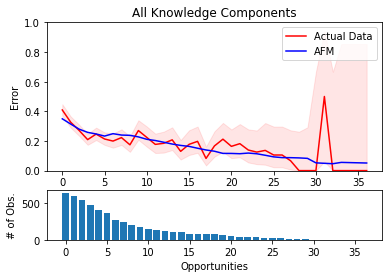

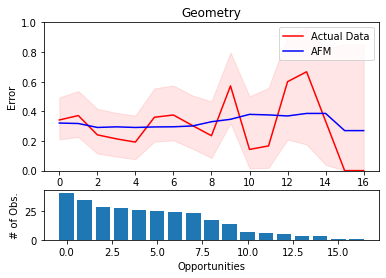

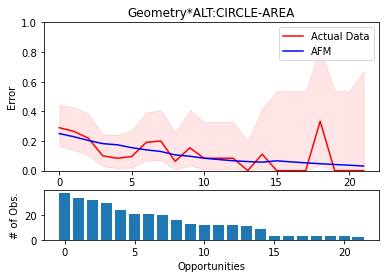

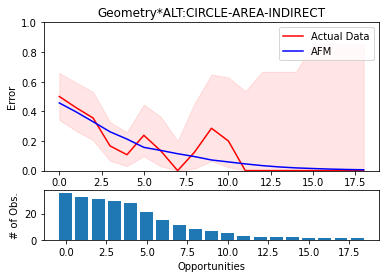

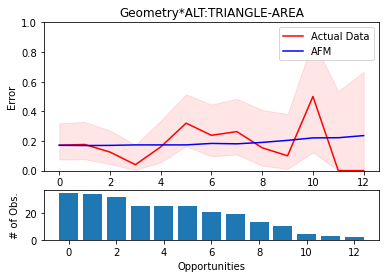

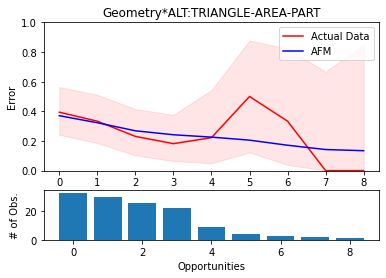

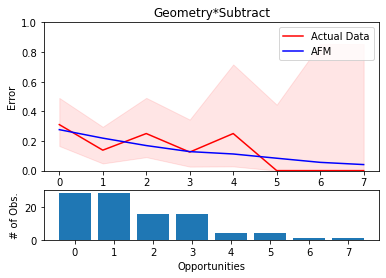

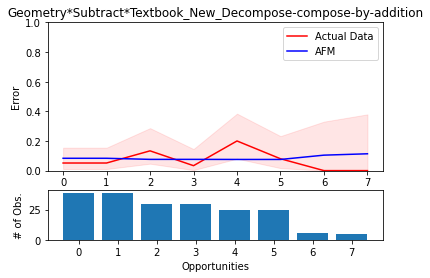

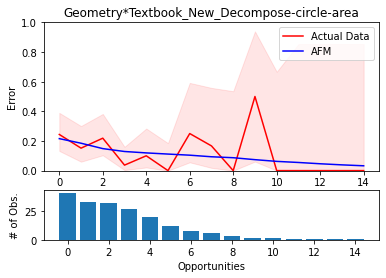

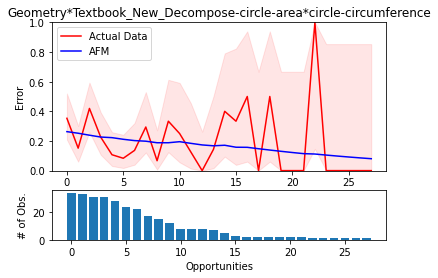

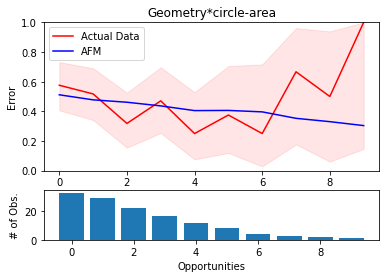

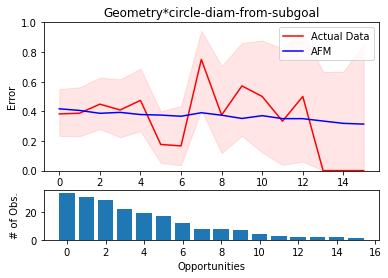

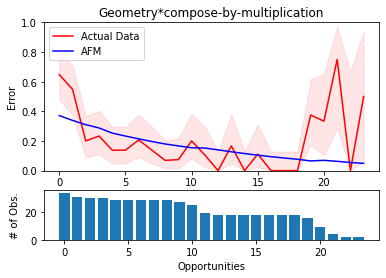

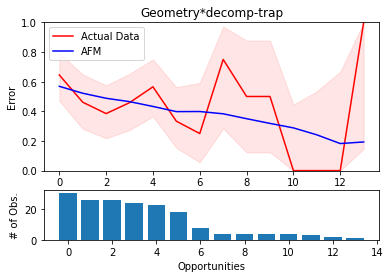

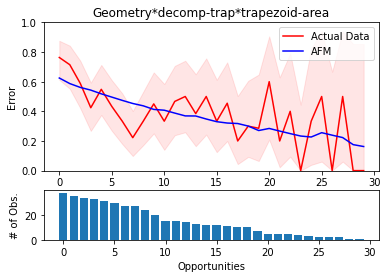

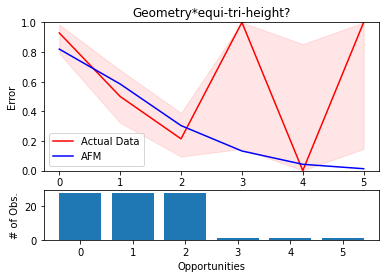

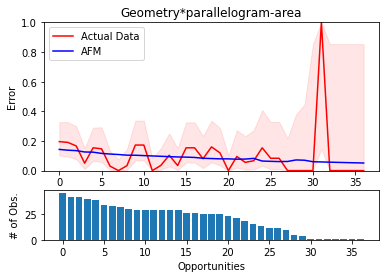

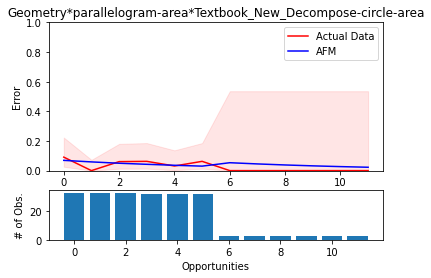

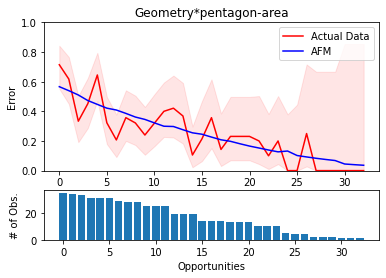

In [22]:
# Generate success rates based on trained model
yAFM = afm.predict_proba(X)

# Generate a list with all KCs
plotkcs = []
plotkcs += list(set([kc for row in kcs for kc in row]))
plotkcs += ['All Knowledge Components']
plotkcs.sort()

# Iterate over the list of KCs
for plot_id, plotkc in enumerate(plotkcs):


    xs = []
    y1 = []
    y2 = []

    for i in range(len(y)):
        for kc in opps[i]:
            if not (kc == plotkc or plotkc == 'All Knowledge Components'):
                continue
            xs.append(opps[i][kc])
            y1.append(y[i])
            y2.append(yAFM[i])
    
    # Calculate mean and 95% confidence intervals for success rate from actual data
    x, y1, lcb, ucb, n_obs = avg_y_by_x(xs, y1)
    
    # Calculate mean for success rate predicted by AFM model
    x, y2, _, _, _ = avg_y_by_x(xs, y2)

    # Transform from success rate to error rate 
    y1 = [1-v for v in y1]
    y2 = [1-v for v in y2]

    
    # Plot curves
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    actual_line, = axs[0].plot(x, y1, color='red', label="Actual Data")
    # human_line, = plt.plot(x, y1, color='red', label="Actual Data")
    axs[0].fill_between(x, lcb, ucb, color='red', alpha=.1)

    lines = [actual_line]


    afm_line, = axs[0].plot(x, y2, color='blue', label="AFM")
    lines.append(afm_line)
    axs[0].legend(handles=lines)
    axs[0].set_title(plotkc)
    axs[1].set_xlabel("Opportunities")
    axs[0].set_ylabel("Error")
    axs[0].set_ylim(0, 1)

    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel("# of Obs.")

    plt.show()


## 3 Extension to PFA
---
In this last part, we will use the framework provided by pyAFM to implement a PFA.  

While AFM only considers the number of previous practice opportunities for a KC, PFA extends the idea by taking into account whether previous answers associated with a given KC were correct or incorrect. As a result, we will apply different learning rates for correct and wrong practice opportunities. As argued by [Pavlik et al. (2009)](http://pact.cs.cmu.edu/koedinger/pubs/AIED%202009%20final%20Pavlik%20Cen%20Keodinger%20corrected.pdf), this extension makes the model sensitive to one of the strongest indicators of student learning: *performance*.

However, to make this adaptation in our case, we need to know at each moment, how many prior successes and prior failures a student has hadso far with respect to a given KC. This information is currently missing in our dataset, but can easily be generated with the existing data.

Let's again start by creating a reduced version of the entire dataframe, containing the relevant data and to which we add to new columns that we call "Prior Success" and "Prior Failure" and initilize with zeros.

In [23]:
# Create another reduced version of the full dataframe 
df3 = df[["Anon Student Id","First Attempt", "KC (LFASearchAICWholeModel3)", "Opportunity (LFASearchAICWholeModel3)"]].copy()

# Add two zero columns for prior success and prior failure
df3["Prior Success"] = 0
df3["Prior Failure"] = 0

# Display first five entries of new dataframe
df3.head()

,Anon Student Id,First Attempt,KC (LFASearchAICWholeModel3),Opportunity (LFASearchAICWholeModel3),Prior Success,Prior Failure
0,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,1,0,0
1,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,2,0,0
2,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,3,0,0
3,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,1,0,0
4,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,2,0,0


The goal now is to fill in the values for both columns using the information from the "Anon Student Id", "First Attempt" and "KC (LFASearchAICWholeModel3)" columns. The counts for prior success and prior failure should be made with respect to each student and each KC. We will therefore loop over all unique values for both categories, representing the combination of a specific student and a specific KC. For each combination we then create a temporary dataframe, that can be used to generate the number of prior successes and prior failures. We iterate over this temporary dataframe while keeping track of the correct and incorrect responses and directly assign the values to our original dataframe.

In [24]:
# Create list of unique KCs and unique student IDs
arrKCs = df['KC (LFASearchAICWholeModel3)'].unique()
arrStu = df['Anon Student Id'].unique()

# Loop of all KCs
for i in range(len(arrKCs)):
    
    # Loop over all students
    for ii in range(len(arrStu)):

        # Create temporary dataframes for different combinations
        df_tmp = df3.loc[(df3['Anon Student Id']==arrStu[ii]) & (df3["KC (LFASearchAICWholeModel3)"] == arrKCs[i])]

        # Initialize counters for prior success and prior failure
        correct = 0
        incorrect = 0

        for iii, row in df_tmp.iterrows():
            df3['Prior Success'].loc[iii]=correct
            df3['Prior Failure'].loc[iii]=incorrect
            if row['First Attempt']=='correct':
                correct +=1
            else:
                incorrect +=1    

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [25]:
# Display first 20 entries of updated dataframe
df3.head(20)

,Anon Student Id,First Attempt,KC (LFASearchAICWholeModel3),Opportunity (LFASearchAICWholeModel3),Prior Success,Prior Failure
0,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,1,0,0
1,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,2,1,0
2,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area,3,2,0
3,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,1,0,0
4,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,2,1,0
5,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*Textbook_New_Decompose-circle-area,1,0,0
6,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,3,2,0
7,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,4,3,0
8,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*Subtract*Textbook_New_Decompose-compo...,1,0,0
9,Stu_02ee1b3f31a6f6a7f4b8012298b2395e,correct,Geometry*parallelogram-area*Textbook_New_Decom...,5,4,0


Above it can be observed, that now both Prior Success and Prior Failure contain meaningful values. We can see that the first three items of this student were related to th KC Geometry-parallelogram-area and they were all answered correctly, making the values in the Prior Success column increment. After a few items related to other KCs, the student is again proposed with items related to this KC starting from row 12. In row 13, the student gives an incorrect answer, making the prior failure increase by one in row 14, while prior success remains the same.

With this new columns, we can now prepare for to train for the PFA model. First we format the data in the same format as used for the AFM model.

In [26]:
n_succ = []
n_fail = []

for i, row in df3.iterrows():
    n_succ.append({row['KC (LFASearchAICWholeModel3)']: int(row['Prior Success'])})
    n_fail.append({row['KC (LFASearchAICWholeModel3)']: int(row['Prior Failure'])})

In [27]:
# Get everything in the right matrix format
sv2 = DictVectorizer()
qv2 = DictVectorizer()
succv2 = DictVectorizer()
failv2 = DictVectorizer()
S2 = sv2.fit_transform(stu)
Q2 = qv2.fit_transform(kcs)
SUCC2 = succv2.fit_transform(n_succ)
FAIL2 = failv2.fit_transform(n_fail)
X2 = hstack((S2, Q2, SUCC2,FAIL2))
y2 = np.array(y)

# Regularize the student intercepts
l22 = [1.0 for i in range(S2.shape[1])]
l22 += [0.0 for i in range(Q2.shape[1])]
l22 += [0.0 for i in range(SUCC2.shape[1])]
l22 += [0.0 for i in range(FAIL2.shape[1])]

# Bound the learning rates to be positive
bounds2 = [(None, None) for i in range(S2.shape[1])]
bounds2 += [(None, None) for i in range(Q2.shape[1])]
bounds2 += [(0, None) for i in range(SUCC2.shape[1])]
bounds2 += [(0, None) for i in range(FAIL2.shape[1])]

X2 = X2.toarray()

__Question:__ Which dimensions do S2, Q2, SUCC2, FAIL2, X2 and y2 have? How many coefficients will we have to estimate? 

__======== YOUR ANSWER HERE ========__

From here the implementation is analogous to the one presented for the AFM.  

In [28]:
pfa = CustomLogistic(bounds=bounds2, l2=l22, fit_intercept=False)
pfa.fit(X2, y2)

CustomLogistic(bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), ...],
               fit_intercept=False,
               l2=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
                   1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...])

In [29]:
coef_s2 = pfa.coef_[0:S2.shape[1]]
coef_s2 = [[k, v, invlogit(v)] for k, v in sv.inverse_transform([coef_s2])[0].items()]
coef_q2 = pfa.coef_[S2.shape[1]:S2.shape[1]+Q2.shape[1]]
coef_qint2 = qv2.inverse_transform([coef_q2])[0]
coef_succ2 = pfa.coef_[S2.shape[1]+Q2.shape[1]:S2.shape[1]+Q2.shape[1]+SUCC2.shape[1]]
coef_succ_slope2 = succv2.inverse_transform([coef_succ2])[0]
coef_fail2 = pfa.coef_[S2.shape[1]+Q.shape[1]+SUCC2.shape[1]:S2.shape[1]+Q2.shape[1]+SUCC2.shape[1]+FAIL2.shape[1]]
coef_fail_slope2 = failv2.inverse_transform([coef_fail2])[0]

kc_vals2 = []
all_kcs2 = set(coef_qint2).union(set(coef_succ_slope2))

for kc in all_kcs2:
    kc_vals2.append([kc, coef_qint2.setdefault(kc, 0.0), invlogit(coef_qint2.setdefault(kc, 0.0)), coef_succ_slope2.setdefault(kc, 0.0),coef_fail_slope2.setdefault(kc, 0.0)])

In [30]:
print(tabulate(sorted(kc_vals2), ['KC Name', 'Intercept (logit)','Intercept (prob)', 'Slope Succ', 'Slope Fail'], floatfmt=".3f"))
print()
print(tabulate(sorted(coef_s2), ['Anon Student Id', 'Intercept (logit)','Intercept (prob)'], floatfmt=".3f"))

KC Name                                                             Intercept (logit)    Intercept (prob)    Slope Succ    Slope Fail
----------------------------------------------------------------  -------------------  ------------------  ------------  ------------
Geometry                                                                        0.634               0.653         0.049         0.000
Geometry*ALT:CIRCLE-AREA                                                        1.100               0.750         0.130         0.094
Geometry*ALT:CIRCLE-AREA-INDIRECT                                               0.075               0.519         0.375         0.190
Geometry*ALT:TRIANGLE-AREA                                                      1.484               0.815         0.000         0.005
Geometry*ALT:TRIANGLE-AREA-PART                                                 0.378               0.593         0.465         0.029
Geometry*Subtract                                             

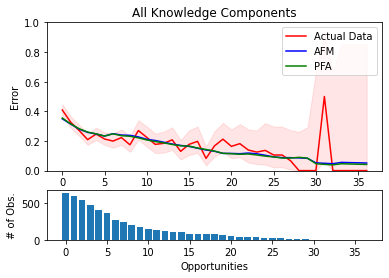

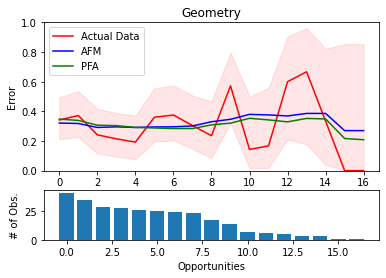

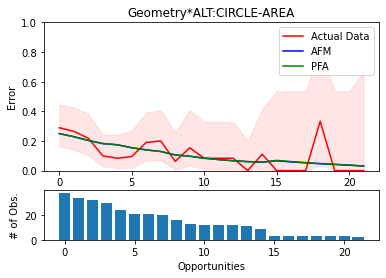

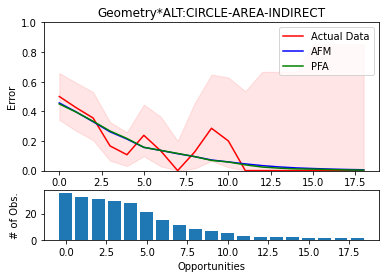

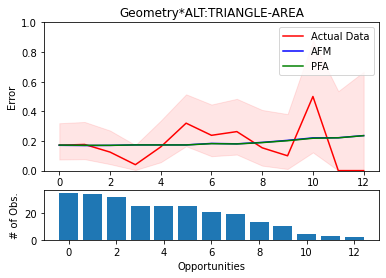

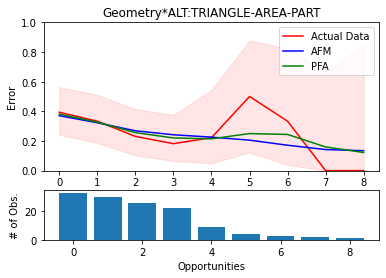

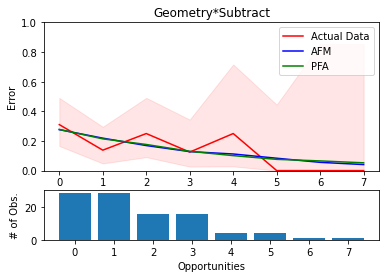

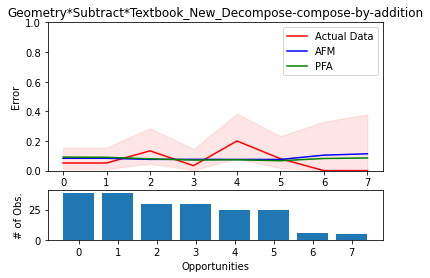

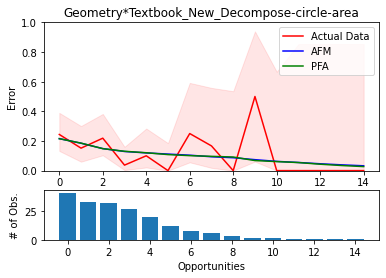

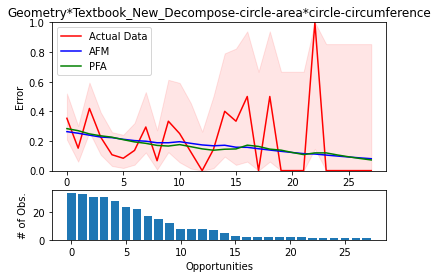

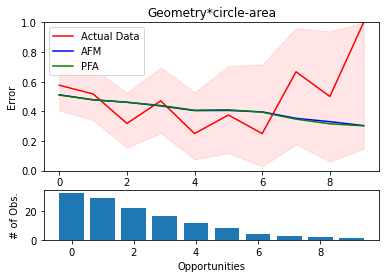

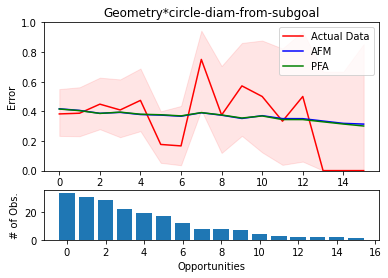

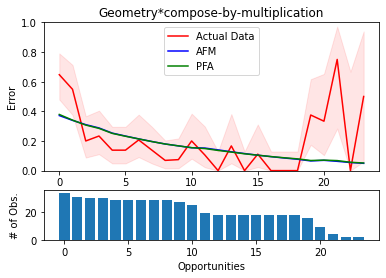

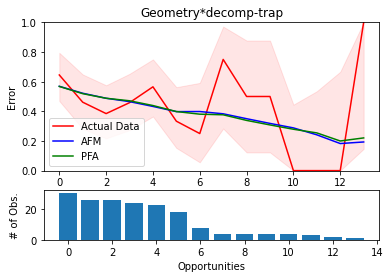

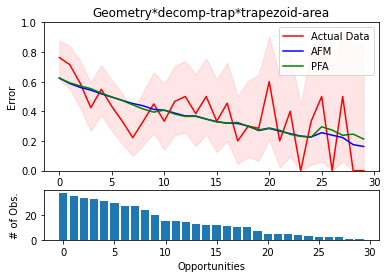

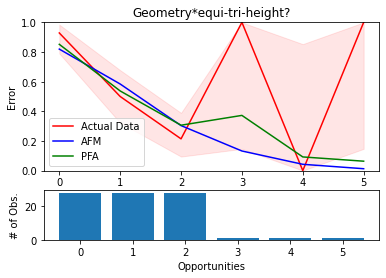

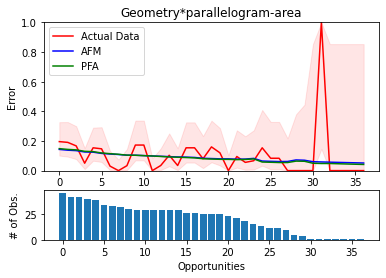

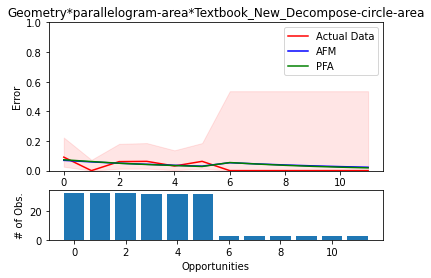

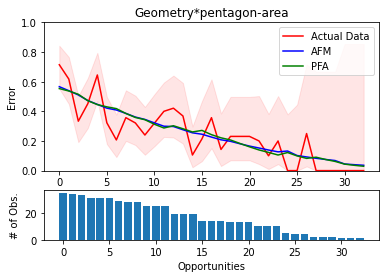

In [31]:
# Generate success rates based on trained model
yPFA = pfa.predict_proba(X2)

# Generate a list with all KCs
plotkcs = []
plotkcs += list(set([kc for row in kcs for kc in row]))
plotkcs += ['All Knowledge Components']
plotkcs.sort()

# Iterate over the list of KCs
for plot_id, plotkc in enumerate(plotkcs):


    xs = []
    y1 = []
    y2 = []
    y3 = []

    for i in range(len(y)):
        for kc in opps[i]:
            if not (kc == plotkc or plotkc == 'All Knowledge Components'):
                continue
            xs.append(opps[i][kc])
            y1.append(y[i])
            y2.append(yAFM[i])
            y3.append(yPFA[i])
    
    # Calculate mean and 95% confidence intervals for success rate from actual data
    x, y1, lcb, ucb, n_obs = avg_y_by_x(xs, y1)
    
    # Calculate mean for success rate predicted by AFM model
    x, y2, _, _, _ = avg_y_by_x(xs, y2)
    
    # Calculate mean for success rate predicted by AFM model
    x, y3, _, _, _ = avg_y_by_x(xs, y3)

    # Transform from success rate to error rate 
    y1 = [1-v for v in y1]
    y2 = [1-v for v in y2]
    y3 = [1-v for v in y3]
    
    # Plot curves
    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})
    actual_line, = axs[0].plot(x, y1, color='red', label="Actual Data")
    # human_line, = plt.plot(x, y1, color='red', label="Actual Data")
    axs[0].fill_between(x, lcb, ucb, color='red', alpha=.1)

    lines = [actual_line]


    afm_line, = axs[0].plot(x, y2, color='blue', label="AFM")
    lines.append(afm_line)
    pfa_line, = axs[0].plot(x, y3, color='green', label="PFA")
    lines.append(pfa_line)
    axs[0].legend(handles=lines)
    axs[0].set_title(plotkc)
    axs[1].set_xlabel("Opportunities")
    axs[0].set_ylabel("Error")
    axs[0].set_ylim(0, 1)

    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel("# of Obs.")

    plt.show()